# Kwantowe sieci neuronowe

W ponizszym kodzie przedstawiono realizację sieci neuronowej dla której jedna z warstw ukrytych zastąpiona została obwodem kwantowym. 
Cały kod zrealizowany został w bibliotece PyTorch i pennylane.

In [ ]:
import pennylane as qml
from pennylane import numpy as np

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import clear_output

print(f"Torch version: {torch.__version__}")
print(f"mac new processor: {torch.backends.mps.is_available()}")

def train(X, Y, model, optimiser, iteration, lossfn, callback = None):
    """ Dodatkowa funkcja pozwalająca wykonać trenowanie naszej sieci neuronowej"""
    for i in range(iteration):
        optimiser.zero_grad()
        prediction = model(X)
        loss = lossfn(Y, prediction)
        loss.backward()
        optimiser.step()
        if callback != None: 
            callback(model, loss)

# dodatkowe ustawienia
torch.manual_seed(123)
n_qubits = 2

Torch version: 2.5.0
mac new processor: True


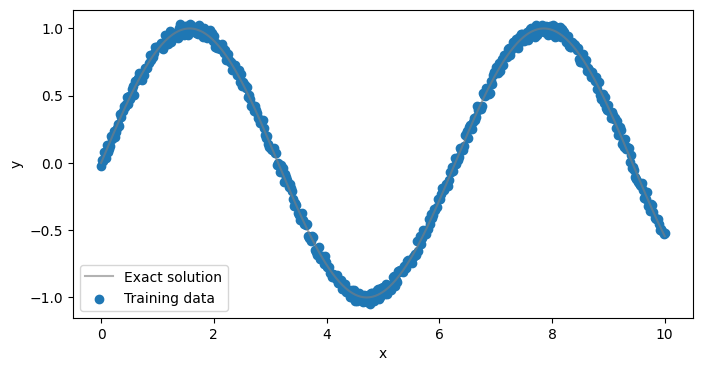

In [2]:
# DANE - funkcja sinus z drobnym szumem
x = torch.linspace(0,10,500).view(-1,1)
y = torch.sin(x)
y = y + 0.1*(torch.rand(500).view(-1,1)-0.5)

plt.figure(figsize=(8,4))
plt.plot(x, torch.sin(x).view(-1,1), color="tab:grey", alpha=0.6, label="Exact solution")
plt.scatter(x, y, label="Training data")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [4]:
class QN(nn.Module):
    '''Classical -> Quantum -> Classical'''

    def __init__(self, N_INPUT: int, N_OUTPUT: int, Q_NODE, N_QUBITS):
        super().__init__()

        self.layers = nn.Sequential(
            # input layer
            nn.Linear(N_INPUT, N_QUBITS),
            # 1st hidden layer as a quantum circuit
            Q_NODE,
            # output layer
            nn.Linear(N_QUBITS, N_OUTPUT)
        )
        

    def forward(self, x):
        return  self.layers(x)

    
def mse(y, y_pred) -> torch.Tensor:
    return torch.mean((y-y_pred)**2)


# NASZ kwantowy PQC - parametryzowany obwód kwantowy dla jednej warstwy ukrytej
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]


n_layers = 5
weight_shapes = {"weights": (n_layers, n_qubits)}
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

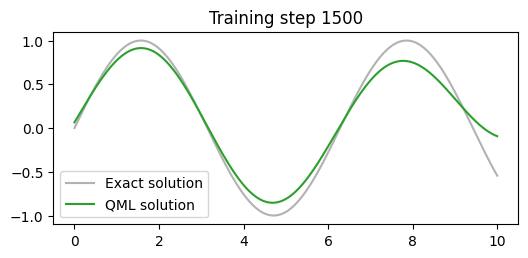

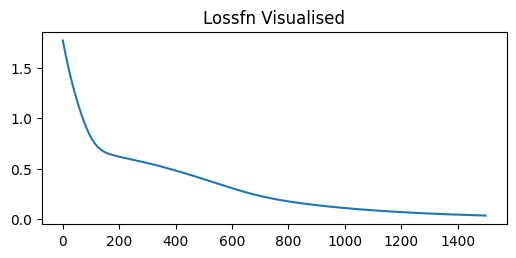

In [ ]:
qmodel = QN(1, 1, qlayer, n_qubits)

#print(qmodel)

x = x.requires_grad_(True)
x_train = x.requires_grad_(True)

learning_rate=1e-3
optimiser = torch.optim.Adam(qmodel.parameters(), lr=learning_rate)

losses = []

def callback(model, loss):
    losses.append(loss.item())

    clear_output(wait=True)
    prediction = model(x).detach()
    plt.figure(figsize=(6,2.5))
    plt.plot(x[:,0].detach(), torch.sin(x)[:,0].detach(), label="Exact solution", color="tab:grey", alpha=0.6)
    plt.plot(x[:,0].detach(), prediction[:,0], label="QML solution", color="tab:green")
    plt.title(f"Training step {len(losses)}")
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,2.5))
    plt.title('Lossfn Visualised')
    plt.plot(losses)
    plt.show()

def special_loss_fn(y, y_pred) -> torch.Tensor:
    return mse(y, y_pred) + torch.mean((y_pred - torch.sin(x))**2)
    


train(x_train, y, qmodel, optimiser, 500, special_loss_fn, callback)

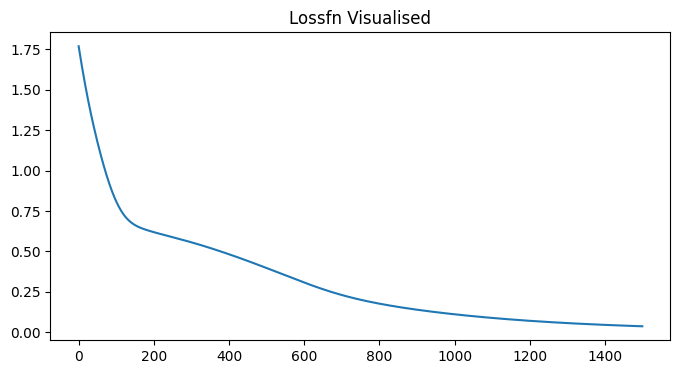

In [6]:
plt.figure(figsize=(8,4))
plt.title('Lossfn Visualised')
plt.plot(losses)

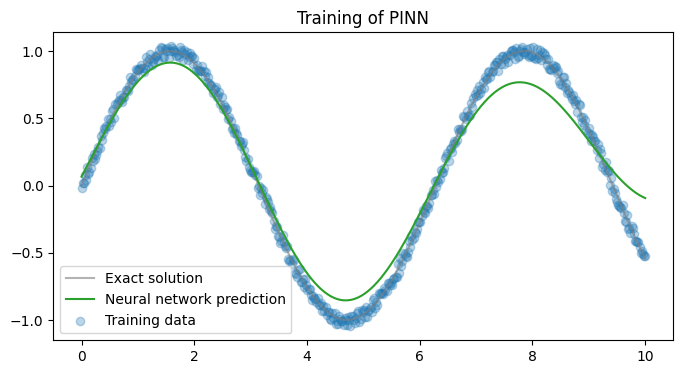

In [7]:
def plot_result(x,y,x_data,y_data,yh, title=None):

    plt.figure(figsize=(8,4))
    plt.title(title)
    plt.plot(x,y, color="tab:grey", alpha=0.6, label="Exact solution")
    plt.plot(x,yh, color="tab:green", label="Neural network prediction")
    plt.scatter(x_data, y_data, alpha=0.3, label='Training data')
    l = plt.legend(loc='best')

plot_result(
    x.detach(),
    torch.sin(x).detach(),
    x.detach(),
    y.detach(),
    qmodel(x).detach(),
    title='Training of PINN'
    )

In [8]:
mse(qmodel(x), torch.sin(x))

tensor(0.0179, grad_fn=<MeanBackward0>)

## Pennylane wprowadzenie

<img src="../img/Qnode.png" />

Obiekt `Qnode` będziemy używać do definicji obwodów kwantowych.
Obiekt ten wspiera wiele bibliotek do obliczeń numerycznych, tzw. interfejsów: 
- `NumPy`, 
- `PyTorch`, 
- `TensorFlow`,
- `JAX`

Domyślnie `QNodes` używa interfejs `NumPy`. Dzięki niemu mamy dostęp do optymalizatorów domyślnych z biblioteki Pennylane. Pozostałe interferjsy wymagają użycia optymalizatorów z innych pakietów. 

PennyLane oferuje kilka [symulatorów](https://pennylane.ai/plugins/):
- 'default.qubit',
- 'default.mixed', 
- 'lightning.qubit', 
- 'default.gaussian', 
- 'default.clifford', 
- 'default.tensor'

## Kod Pennylane  

Pennylane pozwala zrealizować obwód kwantowy (ang. quantum circuit) jako funkcję w Pythonie.


In [1]:
import pennylane as qml

def qc(): # from quantum circuit
    qml.Hadamard(wires=0)
    return qml.counts()

wires oznacza kwantowy podsystem - czyli nasz pojedynczy kubit. Liczymy od 0 nie od 1. 

- Funkcja kwantowa może pobierać klasyczne pamaretry 
- Funkcja kwantowa może zawierać klasyczny flow (przepływ) twojego programu `for` czy `if else`.

Zbiór [kwantowych operatorów](https://docs.pennylane.ai/en/stable/introduction/operations.html) 

## Uruchomienie obwodu kwantowego 

Uruchomienie odbywa się po wyborze `device` z określeniem ilości kubitów (wires)

In [2]:
# domyślnie
dev = qml.device("default.qubit", wires=1)

In [3]:
# można nadać własne nazwy kubitów
dev_unique_wires =  qml.device("default.qubit", wires=['q1','aux'])

W przypadku gdy będziemy chcieli powtórzyć wielokrotnie wykonanie obwodu w celu zebrania statystyki wyników mozemy zdefiniować parametr `shots`

In [4]:
# shots 
shots_list = [5,10,1000]
dev = qml.device("default.qubit", wires=1, shots=shots_list)

`qml.QNode` - łączy naszą kwantową funkcję ze środowiskiem na którym chcemy ją wykonać

In [5]:
circ = qml.QNode(qc, dev)

In [6]:
circ()

({'0': tensor(4, requires_grad=True), '1': tensor(1, requires_grad=True)},
 {'0': tensor(6, requires_grad=True), '1': tensor(4, requires_grad=True)},
 {'0': tensor(491, requires_grad=True), '1': tensor(509, requires_grad=True)})

Łatwiej skorzystać z dekoratora `@qml.qnode` bezpośrednio przy definicji funkcji kwantowej

In [11]:
dev = qml.device("default.qubit", wires=1, shots=1000)
@qml.qnode(dev)
def circuit():
    qml.Hadamard(wires=0)
    return qml.counts()

In [12]:
circuit()

{'0': tensor(467, requires_grad=True), '1': tensor(533, requires_grad=True)}